# Logistic Regression

This logistic regression is based on the Beeler/Daw et al. 2010 paper.
Specifically:

dependent variable: binary choice of port (-1 or 1)

explanatory variables: 
1. the N previous rewards $ r_{t-N:t-1} $
2. the previous choice $c_{t-1}$ to capture a tendency to stay or switch
3. bias variable (1) to capture fixed, overall preference for either port

Note: this model only carries information about ports when it gets a reward. IE -1 = right reward, 1 = left reward, but 0 = no reward (for either side). Should compare models with this information vs. added information about the non-rewarded port choices. 

## 02/19/2017
I just ran the above code on the following data:
    
- `full_9010_02192017.csv`
- `full_8020_02192017.csv`
- `full_7030_02192017.csv`

Which were computed by compiling the following data:
- block range: exactly 50 rewards
- p(choose high Port) >= [p-0.1] where p = p(high Port)

Observations:
1. pseudo-R2 also similar: ~0.64-0.69
2. For (1)  maybe a slight trend that 90-10 had a better model, but not certain. 
3. For each condition, I tried adding in more ports (up to 3) into the past to see if it would help out. For all 3 conditions, decisions for t-N where 2 >= 2 had coefficients = 0. That is, the only non-zero beta for the ports was the most recent one. 

Next step: 


**Figures**

1. Logistic regression performs similarly across different conditions
    - x axis: 90-10,80-20,70-30
    - y axis: F1 score, pseudo-R2
2. Comparing model flexibility across different conditions
    - x axis: number of previous rewards included (i.e. parameters in model)
    - y axis: BIC
    - color: each condition
3. Knowing where the non-rewarded trials are:
    - what if you did the same regression, but instead you know where the non-rewarded trials are?
    - also, compare to adding in previous ports (or rewards in the above scenario) and compare

4. Comparing 'strategies' across conditions
    - train on 90-10, test on 80-20 (and all combinations)

5. Comparing 'strategies' across mice
    - train on one mouse:condition pair, and test on another mouse:condition pair (for the same condition)
    


In [1]:
import sys
sys.path.append('/Users/celia/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/celia/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
import sklearn.tree
%matplotlib inline 

## define function to do logistic regression and some basic evalutions

In [2]:
'''
I compiled the code above into a more compact function so I can cycle through different conditions/mice/etc 
as neccessary
'''

def logreg_and_eval(data,num_rewards=10,test_data=False):
    '''
    Perform Logistic Regression on a pandas dataframe of trials (from feature matrix)
    
    Inputs:
        - data: pandas dataframe of trials (from feature matrix)
    Outputs:
        - logreg: trained logistic regression model (from sklearn)
        - stats:  pandas dataframe with F1, pseudo-R2, and BIC scores from model
        - coeffs: beta coefficients from logreg
    
    '''
    
    from statsmodels.discrete.discrete_model import Logit
    
    port_features = []
    reward_features = []

    #change right port to -1 instead of 0
    for col in data:
        if '_Port' in col:
            data.loc[data[col] == 0,col] = -1
            port_features.append(col)
        elif '_Reward' in col:
            reward_features.append(col)

    #create new feature matrix
    d = data.copy()
    for i in range(len(port_features)):
        d[reward_features[i]] = d[reward_features[i]].values*d[port_features[i]].values
    
    
    #determine the features
    features = reward_features.copy()
    features = features[-1*num_rewards:] #only take the num of rewards specificied in the function
    features.append('1_Port') #append the last decision as a feature
    features.append('Decision') #finally append the decision so we can take it to predict later
    
    #final version of data
    d = d[features].copy() #this now just has the features we want and the decision we want to predict
    
    #do the same thing for the test data if it exists!
    if test_data is not False:
        for col in test_data:
            if '_Port' in col:
                test_data.loc[test_data[col] == 0,col] = -1

        #create new feature matrix
        data_test_new = test_data.copy()
        for i in range(len(port_features)):
            data_test_new[reward_features[i]] = test_data[reward_features[i]].values*test_data[port_features[i]].values
        
        d_test = data_test_new[features].copy()
    
    
        #set training and testing sets now
        x_train = d.iloc[:,:-1].values
        y_train = d.iloc[:,-1].values
        x_test = d_test.iloc[:,:-1].values
        y_test = d_test.iloc[:,-1].values
        
        prev_port_test = d_test['1_Port'].values
        prev_port_test[prev_port_test==-1] = 0
    
    #if there is no test data, then split up the data into training and testing
    else:
        #extract features and decisions
        x = d.iloc[:,:-1].values
        y = d.iloc[:,-1].values

        #split into training and testing
        n_trials = x.shape[0]
        shuf_inds = np.random.permutation(n_trials)
        split_ind = int(n_trials*0.7)

        x_train = x[shuf_inds[:split_ind],:]
        y_train = y[shuf_inds[:split_ind]]

        x_test = x[shuf_inds[split_ind:],:]
        y_test = y[shuf_inds[split_ind:]]
        
        #extract previous port decision for test set
        #these will be used to calculate switches on the test predictions
        prev_port_test = d['1_Port'].values[shuf_inds[split_ind:]]
        prev_port_test[prev_port_test==-1] = 0
    
    '''
    Modeling
    '''
    
    #fit logistic regression
    logreg = sklearn.linear_model.LogisticRegressionCV()
    logreg.fit(x_train,y_train)
    
    #predict on testing set
    y_predict = logreg.predict(x_test)
    y_predict_proba = logreg.predict_proba(x_test)
    
    #model accuracy
    score = logreg.score(x_test,y_test)
    
    #calculating pseudo-R2 and BIC from statsmodel OLS
    model = Logit(y_train,x_train)
    rslt  = model.fit()

    #switches
    y_test_switch = np.abs(y_test - prev_port_test)
    y_predict_switch = np.abs(y_predict - prev_port_test)
    acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_switch,y_test_switch,confusion=False,disp=True)
    
    #extract coefficients
    coefs = logreg.coef_ #retrieve coefs
    coefs = np.append(coefs[0],logreg.intercept_) #add bias coef
    
    #create stats database to return
    d_ = {'pseudo-R2':rslt.prsquared,'F1':F1,'Accuracy':score,'BIC':rslt.bic,'negative loglikelihood':-1*rslt.llf}
    stats = pd.DataFrame(data=d_,index=[0])
    features = features[:-1]
    features.append('Bias')
    
    coefs = pd.DataFrame(data=coefs.reshape(1,-1),columns=features)
    return logreg,stats,coefs

In [3]:
def logreg_and_eval_withports(data,num_rewards=10,num_ports=1,test_data=False):
    '''
    Perform Logistic Regression on a pandas dataframe of trials (from feature matrix)
    
    Inputs:
        - data: pandas dataframe of trials (from feature matrix)
    Outputs:
        - logreg: trained logistic regression model (from sklearn)
        - stats:  pandas dataframe with F1, pseudo-R2, and BIC scores from model
        - coeffs: beta coefficients from logreg
    
    '''
    
    from statsmodels.discrete.discrete_model import Logit
    
    port_features = []
    reward_features = []

    #change right port to -1 instead of 0
    for col in data:
        if '_Port' in col:
            data.loc[data[col] == 0,col] = -1
            port_features.append(col)
        elif '_Reward' in col:
            reward_features.append(col)

    #create new feature matrix
    d = data.copy()
    for i in range(len(port_features)):
        d[reward_features[i]] = d[reward_features[i]].values*d[port_features[i]].values
    
    
    #determine the features
    features = reward_features.copy()
    if num_rewards == 0:
        features = port_features[-1*num_ports:]
    elif num_ports == 0:
        features = features[-1*num_rewards:] #only take the num of rewards specificied in the function
    else:
        features = features[-1*num_rewards:]
        features = np.append(features,port_features[-1*num_ports:])
    
    print(features)
    features = np.append(features,'Decision') #finally append the decision so we can take it to predict later
    
    
    
    #final version of data
    d = d[features].copy() #this now just has the features we want and the decision we want to predict
    
    #do the same thing for the test data if it exists!
    if test_data is not False:
        for col in test_data:
            if '_Port' in col:
                test_data.loc[test_data[col] == 0,col] = -1

        #create new feature matrix
        data_test_new = test_data.copy()
        for i in range(len(port_features)):
            data_test_new[reward_features[i]] = test_data[reward_features[i]].values*test_data[port_features[i]].values
        
        d_test = data_test_new[features].copy()
    
    
        #set training and testing sets now
        x_train = d.iloc[:,:-1].values
        y_train = d.iloc[:,-1].values
        x_test = d_test.iloc[:,:-1].values
        y_test = d_test.iloc[:,-1].values
        
        prev_port_test = test_data['1_Port'].values
        prev_port_test[prev_port_test==-1] = 0
    
    #if there is no test data, then split up the data into training and testing
    else:
        #extract features and decisions
        x = d.iloc[:,:-1].values
        y = d.iloc[:,-1].values

        #split into training and testing
        n_trials = x.shape[0]
        shuf_inds = np.random.permutation(n_trials)
        split_ind = int(n_trials*0.7)

        x_train = x[shuf_inds[:split_ind],:]
        y_train = y[shuf_inds[:split_ind]]

        x_test = x[shuf_inds[split_ind:],:]
        y_test = y[shuf_inds[split_ind:]]
        
        #extract previous port decision for test set
        #these will be used to calculate switches on the test predictions
        prev_port_test = data['1_Port'].values[shuf_inds[split_ind:]]
        prev_port_test[prev_port_test==-1] = 0
    
    '''
    Modeling
    '''
    
    #fit logistic regression
    logreg = sklearn.linear_model.LogisticRegressionCV()
    logreg.fit(x_train,y_train)
    
    #predict on testing set
    y_predict = logreg.predict(x_test)
    y_predict_proba = logreg.predict_proba(x_test)
    
    #model accuracy
    score = logreg.score(x_test,y_test)
    
    #calculating pseudo-R2 and BIC from statsmodel OLS
    model = Logit(y_train,x_train)
    rslt  = model.fit()

    #switches
    y_test_switch = np.abs(y_test - prev_port_test)
    y_predict_switch = np.abs(y_predict - prev_port_test)
    acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_switch,y_test_switch,confusion=False,disp=True)
    
    #extract coefficients
    coefs = logreg.coef_ #retrieve coefs
    coefs = np.append(coefs[0],logreg.intercept_) #add bias coef
    
    #create stats database to return
    d_ = {'pseudo-R2':rslt.prsquared,'F1':F1,'Accuracy':score,'BIC':rslt.bic,'negative loglikelihood':-1*rslt.llf}
    stats = pd.DataFrame(data=d_,index=[0])
    features = features[:-1]
    features = np.append(features,'Bias')
    
    coefs = pd.DataFrame(data=coefs.reshape(1,-1),columns=features)
    return logreg,stats,coefs

# Write here

In [4]:
data_90 = pd.read_csv('/Users/celia/GitHub/mouse_bandit/data/processed_data/markov_9010.csv',index_col=0)
data_80 = pd.read_csv('/Users/celia/GitHub/mouse_bandit/data/processed_data/markov_8020.csv',index_col=0)
data_70 = pd.read_csv('/Users/celia/GitHub/mouse_bandit/data/processed_data/markov_7030.csv',index_col=0)

datas = [data_70,data_80,data_90]
models = []

In [5]:
for i,d in enumerate(datas):
    
    for j in range(30):
        model_curr,stats_curr,coefs_curr = logreg_and_eval(d,num_rewards=7)
        models.append(models)

        if ((i == 0 and j == 0)):
            stats = stats_curr.copy()
            coefs = coefs_curr.copy()
        else:
            stats = stats.append(stats_curr)
            coefs = coefs.append(coefs_curr)

c = np.zeros(90)+70
c[30:] = 80
c[60:] = 90

stats.insert(0,'Condition',c)
coefs.insert(0,'Condition',c)

Optimization terminated successfully.
         Current function value: 0.172900
         Iterations 9
          Predicted NO  Predicted YES
True NO         9388.0           24.0
True YES         602.0            9.0

F1: 0.028

Accuracy on class 0: 1.00
Accuracy on class 1: 0.01

Optimization terminated successfully.
         Current function value: 0.176615
         Iterations 9
          Predicted NO  Predicted YES
True NO         9427.0           25.0
True YES         558.0           13.0

F1: 0.043

Accuracy on class 0: 1.00
Accuracy on class 1: 0.02

Optimization terminated successfully.
         Current function value: 0.171412
         Iterations 9
          Predicted NO  Predicted YES
True NO         9402.0           22.0
True YES         591.0            8.0

F1: 0.025

Accuracy on class 0: 1.00
Accuracy on class 1: 0.01

Optimization terminated successfully.
         Current function value: 0.171938
         Iterations 9
          Predicted NO  Predicted YES
True NO         9

Optimization terminated successfully.
         Current function value: 0.157984
         Iterations 9
          Predicted NO  Predicted YES
True NO        21461.0          119.0
True YES        1253.0           90.0

F1: 0.116

Accuracy on class 0: 0.99
Accuracy on class 1: 0.07

Optimization terminated successfully.
         Current function value: 0.160273
         Iterations 9
          Predicted NO  Predicted YES
True NO        21471.0          172.0
True YES        1155.0          125.0

F1: 0.159

Accuracy on class 0: 0.99
Accuracy on class 1: 0.10

Optimization terminated successfully.
         Current function value: 0.158687
         Iterations 9
          Predicted NO  Predicted YES
True NO        21495.0          111.0
True YES        1233.0           84.0

F1: 0.111

Accuracy on class 0: 0.99
Accuracy on class 1: 0.06

Optimization terminated successfully.
         Current function value: 0.158269
         Iterations 9
          Predicted NO  Predicted YES
True NO        21

Optimization terminated successfully.
         Current function value: 0.250603
         Iterations 7
          Predicted NO  Predicted YES
True NO        13186.0          241.0
True YES        1241.0          272.0

F1: 0.269

Accuracy on class 0: 0.98
Accuracy on class 1: 0.18

Optimization terminated successfully.
         Current function value: 0.250764
         Iterations 7
          Predicted NO  Predicted YES
True NO        13193.0          214.0
True YES        1255.0          278.0

F1: 0.275

Accuracy on class 0: 0.98
Accuracy on class 1: 0.18

Optimization terminated successfully.
         Current function value: 0.249535
         Iterations 7
          Predicted NO  Predicted YES
True NO        13158.0          253.0
True YES        1244.0          285.0

F1: 0.276

Accuracy on class 0: 0.98
Accuracy on class 1: 0.19

Optimization terminated successfully.
         Current function value: 0.250556
         Iterations 7
          Predicted NO  Predicted YES
True NO        13

# Comparing beta coefficients across conditions

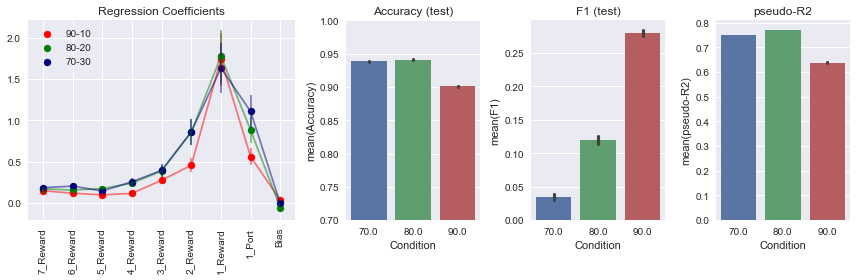

In [6]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1,4,width_ratios=[2,1,1,1])

plt.subplot(gs[0])
plt.errorbar(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 90].iloc[:,1:].mean(),
             yerr= coefs[coefs['Condition'] == 90].iloc[:,1:].mean() / np.sqrt(np.sum(coefs['Condition'] == 90)),
             color='red',alpha=0.5)
plt.errorbar(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 80].iloc[:,1:].mean(),
             yerr= coefs[coefs['Condition'] == 80].iloc[:,1:].mean() / np.sqrt(np.sum(coefs['Condition'] == 80)),
             color='green',alpha=0.5)
plt.errorbar(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 70].iloc[:,1:].mean(),
             yerr= coefs[coefs['Condition'] == 70].iloc[:,1:].mean() / np.sqrt(np.sum(coefs['Condition'] == 70)),
             color='navy',alpha=0.5)

plt.scatter(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 90].iloc[:,1:].mean(),
            color='red',label='90-10',s=50)
plt.scatter(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 80].iloc[:,1:].mean(),
            color='green',label='80-20',s=50)
plt.scatter(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 70].iloc[:,1:].mean(),
            color='navy',label='70-30',s=50)

plt.legend(loc='upper left')
plt.xticks(np.arange(coefs.shape[1]),coefs.columns.values[1:],rotation='vertical')
plt.xlim(-0.5,8.5)
plt.title('Regression Coefficients')

plt.subplot(gs[1])
sns.barplot(x='Condition',y='Accuracy',data=stats)
plt.title('Accuracy (test)')
plt.ylim(0.7,1)

plt.subplot(gs[2])
sns.barplot(x='Condition',y='F1',data=stats)
plt.title('F1 (test)')
#plt.ylim(0.7,1)

plt.subplot(gs[3])
sns.barplot(x='Condition',y='pseudo-R2',data=stats)
plt.title('pseudo-R2')
#plt.ylim(0.5,0.8)

plt.tight_layout()

## Test number of parameters / model flexibility vs BIC

In [7]:
stats.head(2)

,Condition,Accuracy,BIC,F1,negative loglikelihood,pseudo-R2
0,70.0,0.937544,8167.357356,0.027950,4043.439107,0.750557
0,70.0,0.941834,8341.131779,0.042693,4130.326318,0.745193


In [8]:
d = data_80.copy()
stats = pd.DataFrame(columns=['Accuracy','BIC','negative loglikelihood','pseudo-R2','No. parameters'])

for i,n in enumerate(np.arange(10,0,-1)):
    
    for j in enumerate(range(30)):
        model_curr,stats_curr,coefs_curr = logreg_and_eval(d,num_rewards=n)
        models.append(models)
        stats_curr['No. parameters'] = n
        stats = stats.append(stats_curr)

Optimization terminated successfully.
         Current function value: 0.159853
         Iterations 9
          Predicted NO  Predicted YES
True NO        21470.0          100.0
True YES        1248.0          105.0

F1: 0.135

Accuracy on class 0: 1.00
Accuracy on class 1: 0.08

Optimization terminated successfully.
         Current function value: 0.160526
         Iterations 9
          Predicted NO  Predicted YES
True NO        21535.0           97.0
True YES        1191.0          100.0

F1: 0.134

Accuracy on class 0: 1.00
Accuracy on class 1: 0.08

Optimization terminated successfully.
         Current function value: 0.157509
         Iterations 9
          Predicted NO  Predicted YES
True NO        21448.0          109.0
True YES        1260.0          106.0

F1: 0.134

Accuracy on class 0: 0.99
Accuracy on class 1: 0.08

Optimization terminated successfully.
         Current function value: 0.158167
         Iterations 9
          Predicted NO  Predicted YES
True NO        21

Optimization terminated successfully.
         Current function value: 0.159231
         Iterations 9
          Predicted NO  Predicted YES
True NO        21458.0          118.0
True YES        1238.0          109.0

F1: 0.139

Accuracy on class 0: 0.99
Accuracy on class 1: 0.08

Optimization terminated successfully.
         Current function value: 0.158878
         Iterations 9
          Predicted NO  Predicted YES
True NO        21483.0          108.0
True YES        1240.0           92.0

F1: 0.120

Accuracy on class 0: 0.99
Accuracy on class 1: 0.07

Optimization terminated successfully.
         Current function value: 0.158361
         Iterations 9
          Predicted NO  Predicted YES
True NO        21482.0          101.0
True YES        1256.0           84.0

F1: 0.110

Accuracy on class 0: 1.00
Accuracy on class 1: 0.06

Optimization terminated successfully.
         Current function value: 0.159800
         Iterations 9
          Predicted NO  Predicted YES
True NO        21

Optimization terminated successfully.
         Current function value: 0.158929
         Iterations 9
          Predicted NO  Predicted YES
True NO        21455.0          128.0
True YES        1259.0           81.0

F1: 0.105

Accuracy on class 0: 0.99
Accuracy on class 1: 0.06

Optimization terminated successfully.
         Current function value: 0.158418
         Iterations 9
          Predicted NO  Predicted YES
True NO        21471.0          112.0
True YES        1247.0           93.0

F1: 0.120

Accuracy on class 0: 0.99
Accuracy on class 1: 0.07

Optimization terminated successfully.
         Current function value: 0.158146
         Iterations 9
          Predicted NO  Predicted YES
True NO        21466.0          113.0
True YES        1250.0           94.0

F1: 0.121

Accuracy on class 0: 0.99
Accuracy on class 1: 0.07

Optimization terminated successfully.
         Current function value: 0.159155
         Iterations 9
          Predicted NO  Predicted YES
True NO        21

Optimization terminated successfully.
         Current function value: 0.158698
         Iterations 9
          Predicted NO  Predicted YES
True NO        21464.0          136.0
True YES        1226.0           97.0

F1: 0.125

Accuracy on class 0: 0.99
Accuracy on class 1: 0.07

Optimization terminated successfully.
         Current function value: 0.157780
         Iterations 9
          Predicted NO  Predicted YES
True NO        21459.0          126.0
True YES        1257.0           81.0

F1: 0.105

Accuracy on class 0: 0.99
Accuracy on class 1: 0.06

Optimization terminated successfully.
         Current function value: 0.159451
         Iterations 9
          Predicted NO  Predicted YES
True NO        21477.0          112.0
True YES        1243.0           91.0

F1: 0.118

Accuracy on class 0: 0.99
Accuracy on class 1: 0.07

Optimization terminated successfully.
         Current function value: 0.158282
         Iterations 9
          Predicted NO  Predicted YES
True NO        21

Optimization terminated successfully.
         Current function value: 0.159965
         Iterations 9
          Predicted NO  Predicted YES
True NO        21496.0          117.0
True YES        1233.0           77.0

F1: 0.102

Accuracy on class 0: 0.99
Accuracy on class 1: 0.06

Optimization terminated successfully.
         Current function value: 0.159837
         Iterations 9
          Predicted NO  Predicted YES
True NO        21508.0           97.0
True YES        1230.0           88.0

F1: 0.117

Accuracy on class 0: 1.00
Accuracy on class 1: 0.07

Optimization terminated successfully.
         Current function value: 0.160389
         Iterations 9
          Predicted NO  Predicted YES
True NO        21517.0           91.0
True YES        1235.0           80.0

F1: 0.108

Accuracy on class 0: 1.00
Accuracy on class 1: 0.06

Optimization terminated successfully.
         Current function value: 0.159936
         Iterations 9
          Predicted NO  Predicted YES
True NO        21

Optimization terminated successfully.
         Current function value: 0.159664
         Iterations 9
          Predicted NO  Predicted YES
True NO        21479.0          114.0
True YES        1250.0           80.0

F1: 0.105

Accuracy on class 0: 0.99
Accuracy on class 1: 0.06

Optimization terminated successfully.
         Current function value: 0.160746
         Iterations 9
          Predicted NO  Predicted YES
True NO        21546.0          107.0
True YES        1187.0           83.0

F1: 0.114

Accuracy on class 0: 1.00
Accuracy on class 1: 0.07

Optimization terminated successfully.
         Current function value: 0.159363
         Iterations 9
          Predicted NO  Predicted YES
True NO        21484.0          105.0
True YES        1235.0           99.0

F1: 0.129

Accuracy on class 0: 1.00
Accuracy on class 1: 0.07

Optimization terminated successfully.
         Current function value: 0.159985
         Iterations 9
          Predicted NO  Predicted YES
True NO        21

Optimization terminated successfully.
         Current function value: 0.160337
         Iterations 9
          Predicted NO  Predicted YES
True NO        21516.0           84.0
True YES        1257.0           66.0

F1: 0.090

Accuracy on class 0: 1.00
Accuracy on class 1: 0.05

Optimization terminated successfully.
         Current function value: 0.161585
         Iterations 9
          Predicted NO  Predicted YES
True NO        21552.0           88.0
True YES        1225.0           58.0

F1: 0.081

Accuracy on class 0: 1.00
Accuracy on class 1: 0.05

Optimization terminated successfully.
         Current function value: 0.158619
         Iterations 9
          Predicted NO  Predicted YES
True NO        21489.0           84.0
True YES        1293.0           57.0

F1: 0.076

Accuracy on class 0: 1.00
Accuracy on class 1: 0.04

Optimization terminated successfully.
         Current function value: 0.161576
         Iterations 9
          Predicted NO  Predicted YES
True NO        21

Optimization terminated successfully.
         Current function value: 0.160178
         Iterations 9
          Predicted NO  Predicted YES
True NO        21541.0           44.0
True YES        1311.0           27.0

F1: 0.038

Accuracy on class 0: 1.00
Accuracy on class 1: 0.02

Optimization terminated successfully.
         Current function value: 0.159975
         Iterations 9
          Predicted NO  Predicted YES
True NO        21529.0           50.0
True YES        1315.0           29.0

F1: 0.041

Accuracy on class 0: 1.00
Accuracy on class 1: 0.02

Optimization terminated successfully.
         Current function value: 0.161263
         Iterations 9
          Predicted NO  Predicted YES
True NO        21568.0           43.0
True YES        1285.0           27.0

F1: 0.039

Accuracy on class 0: 1.00
Accuracy on class 1: 0.02

Optimization terminated successfully.
         Current function value: 0.162416
         Iterations 9
          Predicted NO  Predicted YES
True NO        21

Optimization terminated successfully.
         Current function value: 0.166227
         Iterations 9
          Predicted NO  Predicted YES
True NO        21658.0            0.0
True YES        1265.0            0.0

F1: 0.000

Accuracy on class 0: 1.00
Accuracy on class 1: 0.00

Optimization terminated successfully.
         Current function value: 0.162636
         Iterations 9
          Predicted NO  Predicted YES
True NO        21539.0            0.0
True YES        1384.0            0.0

F1: 0.000

Accuracy on class 0: 1.00
Accuracy on class 1: 0.00

Optimization terminated successfully.
         Current function value: 0.166473
         Iterations 9
          Predicted NO  Predicted YES
True NO        21626.0            0.0
True YES        1297.0            0.0

F1: 0.000

Accuracy on class 0: 1.00
Accuracy on class 1: 0.00

Optimization terminated successfully.
         Current function value: 0.164826
         Iterations 9
          Predicted NO  Predicted YES
True NO        21

Optimization terminated successfully.
         Current function value: 0.176808
         Iterations 8
          Predicted NO  Predicted YES
True NO        21546.0            0.0
True YES        1377.0            0.0

F1: 0.000

Accuracy on class 0: 1.00
Accuracy on class 1: 0.00

Optimization terminated successfully.
         Current function value: 0.176148
         Iterations 9
          Predicted NO  Predicted YES
True NO        21555.0            0.0
True YES        1368.0            0.0

F1: 0.000

Accuracy on class 0: 1.00
Accuracy on class 1: 0.00

Optimization terminated successfully.
         Current function value: 0.177425
         Iterations 8
          Predicted NO  Predicted YES
True NO        21575.0            0.0
True YES        1348.0            0.0

F1: 0.000

Accuracy on class 0: 1.00
Accuracy on class 1: 0.00

Optimization terminated successfully.
         Current function value: 0.177162
         Iterations 8
          Predicted NO  Predicted YES
True NO        21

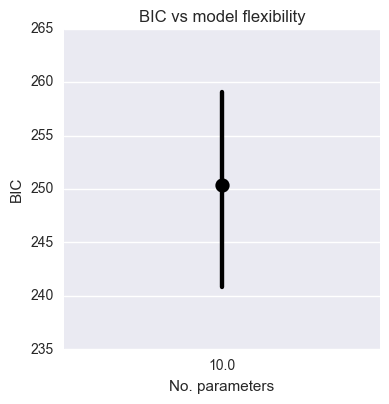

In [32]:
plt.figure(figsize=(10,4))
sns.factorplot(x='No. parameters',y='BIC',data=stats,color='black')
plt.title('BIC vs model flexibility')

In [ ]:
BIC = np.zeros((10,10))
F1 = np.zeros((10,10))
R2 = np.zeros((10,10))
acc = np.zeros((10,10))

for i in range(10):
    for j in range(10):
        if not ((j==0) & (i==0)):
            model_curr,stats_curr,coefs_curr = logreg_and_eval_withports(d,num_rewards=i,num_ports=j)
            BIC[i,j] = stats_curr['BIC'].values
            F1[i,j] = stats_curr['F1'].values
            R2[i,j] = stats_curr['pseudo-R2'].values
            acc[i,j] = stats_curr['Accuracy'].values

In [ ]:
plt.figure(figsize=(20,5))
plt.suptitle('Model behavior vs # of rewards and decisions included',x=0.5,y=1.05,fontsize=20)

plt.subplot(141)
sns.heatmap(BIC,vmin=1500,vmax=3000)
plt.xlabel('# previous decisions in model',fontsize=15)
plt.ylabel('# previous reward outcomes in model',fontsize=15)
plt.title('BIC',fontsize=15)

plt.subplot(142)
sns.heatmap(F1)
plt.xlabel('# previous decisions in model',fontsize=15)
plt.ylabel('# previous reward outcomes in model',fontsize=15)
plt.title('F1',fontsize=15)

plt.subplot(143)
sns.heatmap(R2,vmin=0.5)
plt.xlabel('# previous decisions in model',fontsize=15)
plt.ylabel('# previous reward outcomes in model',fontsize=15)
plt.title('R2')

plt.subplot(144)
sns.heatmap(acc,vmin=0.8)
plt.xlabel('# previous decisions in model',fontsize=15)
plt.ylabel('# previous reward outcomes in model',fontsize=15)
plt.title('Accuracy')

plt.tight_layout()

# Training / testing on different conditions

### 1. Train on 90-10, test on 80-20 and 70-30

In [ ]:
for i,d in enumerate([data_90,data_80,data_70]):
    
    if i == 0:
        model,stats,coefs = logreg_and_eval(d)
    else:
        model,stats_curr,coefs_curr = logreg_and_eval(data_90,test_data = d)
        
        stats = stats.append(stats_curr)
        coefs = coefs.append(coefs_curr)

stats_90 = stats.drop(['BIC','negative loglikelihood','pseudo-R2'],axis=1)

In [ ]:
stats_90['Testing Condition'] = [90,80,70]
stats_90

So this is interesting - accuracy stays pretty much the same across conditions, but F1 goes way down. And if we take a look at the confusion tables above, we can see it is because the accuracy on the switches went down (and accuracy on stays went up. 

### 2. Train on 80-20

In [ ]:
for i,d in enumerate([data_80,data_90,data_70]):
    
    if i == 0:
        model,stats,coefs = logreg_and_eval(d)
    else:
        model,stats_curr,coefs_curr = logreg_and_eval(data_80,test_data = d)
        
        stats = stats.append(stats_curr)
        coefs = coefs.append(coefs_curr)

stats_80 = stats.drop(['BIC','negative loglikelihood','pseudo-R2'],axis=1)

stats_80['Testing Condition'] = [80,90,70]
stats_80

### 3. Train on 70-30

In [ ]:
for i,d in enumerate([data_70,data_80,data_90]):
    
    if i == 0:
        model,stats,coefs = logreg_and_eval(d)
    else:
        model,stats_curr,coefs_curr = logreg_and_eval(data_70,test_data = d)
        
        stats = stats.append(stats_curr)
        coefs = coefs.append(coefs_curr)

stats_70 = stats.drop(['BIC','negative loglikelihood','pseudo-R2'],axis=1)

stats_70['Testing Condition'] = [70,80,90]
stats_70

In [ ]:
f1s = np.vstack((stats_90['F1'].values,
               stats_80['F1'].values[[1,0,2]],
               stats_70['F1'].values[[2,1,0]]))
sns.heatmap(f1s)
plt.xticks([0.5,1.5,2.5],['90','80','70'])
plt.yticks([0.5,1.5,2.5],['70','80','90'])
plt.ylabel('Testing Condition')
plt.xlabel('Training Condition')
plt.title('F1 scores when trained & tested on different conditions')

So if this is right, it means that the rules are different - what predicts a switch in 90-10 does not predict a switch in 80-20. But since most of the trials follow the last one, the accuracy doesn't drop very much. So it appears to be working fine, even though it is not. 

Can the difference be explained in the small differences in beta coefficient values? It must be ... what else is there? They seem similar enough that I'm surprised it makes such a difference. 

Let's go on to train and test on separate mice:

# Train/test on separate mice

First let's take a quick look at the mice's performances - specifically just at p(choose high P port):

In [ ]:
data_90.insert(0,'Condition',0.9)
data_80.insert(0,'Condition',0.8)
data_70.insert(0,'Condition',0.7)

In [ ]:
all_data = data_90.append(data_80)
all_data = all_data.append(data_70)
all_data.shape

In [ ]:
sns.factorplot(x='Condition',y='Higher p port',hue='Mouse ID',data = all_data,legend=False,size=5,aspect=1.7)
plt.legend(bbox_to_anchor=(1.2,1))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Condition',fontsize=20)
plt.ylabel('rate higher prob port chosen',fontsize=20)
plt.title('Average p(choose better port) for each mouse across conditions',fontsize=20,x=0.5,y=1.1)

Okay, so based on this. Let's start with 80-20, and do a few different comparisons. 

1. Start by training with harry, and testing on all the others. 
2. Then try training on volde, testing on all others. 
3. Finally train on someone in the middle - like Tom or q45, and test on others

In [ ]:
'''
Loop through mice
'''
mice = np.unique(data_80['Mouse ID'].values)

stats = pd.DataFrame(columns=['Accuracy','F1','Training Mouse','Testing Mouse'])
test_mice = []
train_mice = []

for mouse_train in mice:

    d_train = data_80[data_80['Mouse ID'] == mouse_train].copy()

    for i,mouse_test in enumerate(mice):
        d_test = data_80[data_80['Mouse ID'] == mouse_test].copy()

        if i == 0:
            model,stats_curr,coefs = logreg_and_eval(d_train,test_data = d_test)
            stats_curr = stats_curr.drop(['BIC','negative loglikelihood','pseudo-R2'],axis=1)
            stats = stats.append(stats_curr)
        else:
            model,stats_curr,coefs_curr = logreg_and_eval(d_train,test_data = d_test)
            stats_curr = stats_curr.drop(['BIC','negative loglikelihood','pseudo-R2'],axis=1)
            stats= stats.append(stats_curr)
            coefs = coefs.append(coefs_curr)

        test_mice.append(mouse_test)
        train_mice.append(mouse_train)

stats['Testing Mouse'] = test_mice
stats['Training Mouse'] = train_mice
acc_matrix = np.reshape(stats['Accuracy'].values,(len(mice),-1)).T
F1_matrix = np.reshape(stats['F1'].values,(len(mice),-1)).T

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.heatmap(acc_matrix)
plt.xticks(np.arange(11)+0.5,mice,rotation='vertical')
plt.yticks(np.arange(11)+0.5,mice[::-1],rotation='horizontal')
plt.xlabel('Training Mouse')
plt.ylabel('Testing Mouse')
plt.title('Accuracy')

plt.subplot(122)
sns.heatmap(F1_matrix)
plt.xticks(np.arange(11)+0.5,mice,rotation='vertical')
plt.yticks(np.arange(11)+0.5,mice[::-1],rotation='horizontal')
plt.xlabel('Training Mouse')
plt.ylabel('Testing Mouse')
plt.title('F1')

In [ ]:
data_80.head(2)

In [ ]:
u_switch = np.zeros(len(mice))
u_acc = np.zeros(len(mice))

for i,mouse in enumerate(mice):
    u_switch[i] = data_80[data_80['Mouse ID']== mouse]['Switch'].mean()
    u_acc[i] = data_80[data_80['Mouse ID']== mouse]['Higher p port'].mean()

In [ ]:
colors = sns.color_palette('hls',n_colors=len(mice))
plt.figure(figsize=(12,5))
plt.suptitle('Higher switch rates anti-correlate with accuracy on test mice',fontsize=20,x=0.5,y=1.1)
plt.subplot(121)
for i,mouse in enumerate(mice):
    plt.scatter(u_switch[i],acc_matrix[i,:].mean(),label=mouse,c=colors[i],s=50)
#plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('mean switch rate')
plt.ylabel('mean accuracy when used as test mouse')
plt.ylim(0.75,1)
plt.xlim(0,0.22)
plt.title('Testing accuracy vs mean switch rate')


plt.subplot(122)
for i,mouse in enumerate(mice):
    plt.scatter(u_switch[i],acc_matrix[:,i].mean(),label=mouse,c=colors[i],s=50)
plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('mean switch rate')
plt.ylabel('mean accuracy when used as train mouse')
plt.ylim(0.75,1)
plt.xlim(0,0.22)
plt.title('Training accuracy vs mean switch rate')

plt.tight_layout()

In [ ]:
colors = sns.color_palette('hls',n_colors=len(mice))
plt.figure(figsize=(12,5))
plt.suptitle('Higher switch rates correlate with F1 score on test mice',fontsize=20,x=0.5,y=1.1)
plt.subplot(121)
for i,mouse in enumerate(mice):
    plt.scatter(u_switch[i],F1_matrix[i,:].mean(),label=mouse,c=colors[i],s=50)
#plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('mean switch rate')
plt.ylabel('mean F1 when used as test mouse')
#plt.ylim(0.75,1)
#plt.xlim(0,0.22)
plt.title('Testing F1 vs mean switch rate')


plt.subplot(122)
for i,mouse in enumerate(mice):
    plt.scatter(u_switch[i],F1_matrix[:,i].mean(),label=mouse,c=colors[i],s=50)
plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('mean switch rate')
plt.ylabel('mean F1 when used as train mouse')
#plt.ylim(0.75,1)
#plt.xlim(0,0.22)
plt.title('Training F1 vs mean switch rate')

plt.tight_layout()

In [ ]:
colors = sns.color_palette('hls',n_colors=len(mice))
plt.figure(figsize=(12,5))
plt.suptitle('Better behavior correlates with accuracy score on test mice',fontsize=20,x=0.5,y=1.1)
plt.subplot(121)
for i,mouse in enumerate(mice):
    plt.scatter(u_acc[i],acc_matrix[i,:].mean(),label=mouse,c=colors[i],s=50)
#plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('mean p(high p port)')
plt.ylabel('mean acc when used as test mouse')
#plt.ylim(0.75,1)
#plt.xlim(0,0.22)
plt.title('Testing Acc vs mean p(high p port)')


plt.subplot(122)
for i,mouse in enumerate(mice):
    plt.scatter(u_acc[i],acc_matrix[:,i].mean(),label=mouse,c=colors[i],s=50)
plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('mean p(high p port)')
plt.ylabel('mean acc when used as train mouse')
#plt.ylim(0.75,1)
#plt.xlim(0,0.22)
plt.title('Training acc vs mean p(high p port)')

plt.tight_layout()

In [ ]:
colors = sns.color_palette('hls',n_colors=len(mice))
plt.figure(figsize=(12,5))
plt.suptitle('p(high p port) vs F1 score',fontsize=20,x=0.5,y=1.1)
plt.subplot(121)
for i,mouse in enumerate(mice):
    plt.scatter(u_acc[i],F1_matrix[i,:].mean(),label=mouse,c=colors[i],s=50)
#plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('p(high p port)')
plt.ylabel('mean F1 when used as test mouse')
#plt.ylim(0.75,1)
#plt.xlim(0,0.22)
plt.title('Testing F1 vs mean switch rate')


plt.subplot(122)
for i,mouse in enumerate(mice):
    plt.scatter(u_acc[i],F1_matrix[:,i].mean(),label=mouse,c=colors[i],s=50)
plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('p(high p port)')
plt.ylabel('mean F1 when used as train mouse')
#plt.ylim(0.75,1)
#plt.xlim(0,0.22)
plt.title('Training F1 vs mean switch rate')

plt.tight_layout()